In [1]:
from read_data import read_enhanced_microscore_dataset
from sklearn.decomposition import PCA
from plots import first_plot, second_plot, third_plot, forth_plot, plot_performance, fith_plot
import pandas as pd
from sklearn.preprocessing import StandardScaler
import numpy as np
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt

In [2]:
df = read_enhanced_microscore_dataset()

In [3]:
df_base = df[[
    "Habitaciones",
    "Aseos",
    "Terraza",
    "Piscina",
    "Garaje",
    "Precio",
    "Metros",
    # "CodigoPostal", # Eliminado
    "Latitud",
    "Longitud",
    'Caracteristicas'
]]

In [4]:
df_microscore = df[[
    "Habitaciones",
    "Aseos",
    "Terraza",
    "Piscina",
    "Garaje",
    "Precio",
    "Metros",
    # "CodigoPostal", # Eliminado
    "Latitud",
    "Longitud",
    "RentaBrutaHogar",
    "RentaBrutaPersona",
    "poblacion_2023",
    "%_servicios",
    "densidad_inm_m2",
    "%_agricultura",
    "%_industria",
    "%_construccion",
    'Caracteristicas',
    'University_Distance',
    'School_Distance', 'Kindergarten_Distance', 'City Center_Distance',
       'Supermarket_Distance', 'Bakery_Distance', 'Hospital_Distance',
       'Pharmacy_Distance', 'Restaurant_Distance', 'Café_Distance',
       'Park_Distance', 'Gym_Distance', 'Movie Theater_Distance',
       'Theater_Distance', 'Shopping Mall_Distance', 'Bus Stop_Distance',
       'Metro Station_Distance', 'Score'
]]

In [5]:
def prepare_data(df):
    categorical_cols = ['Caracteristicas']
    df = pd.get_dummies(df, columns=categorical_cols)
    df = df.fillna(-1)
    return df

In [6]:
df_base =prepare_data(df_base)
df_microscore =prepare_data(df_microscore)

In [7]:
def pca_dimension(df):
    X = df.drop(columns=['Precio'])
    y = df['Precio']
    
    # Standardize
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)
    
    # PCA
    pca = PCA()
    principalComponents = pca.fit_transform(X_scaled)
    
    # Crear DF con los componentes de la PCA
    principal_df = pd.DataFrame(
        data=principalComponents,
        columns=['PC{}'.format(i + 1) for i in range(len(X.columns))]
    )
    
    # Añadir precio
    principal_df['Precio'] = y.reset_index(drop=True)
    
    # Correlacion entre precio y la componente principal
    corr_matrix = principal_df.corr()
    precio_corr = corr_matrix['Precio'].drop('Precio')


    # Varianza
    explained_variance = pca.explained_variance_ratio_
    
    # Varianza acumulativa
    cumulative_variance = np.cumsum(explained_variance)
    
    plt.figure(figsize=(8, 5))
    plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center',
            label='Varianza explicada individual')
    plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Varianza explicada acumulada')
    plt.title('Varianza explicada por componentes principales')
    plt.xlabel('Índice de componentes principales')
    plt.ylabel('Proporción de varianza explicada')
    plt.legend(loc='best')
    plt.grid(True)
    plt.show()

    return precio_corr, pca, principalComponents
    
     

In [8]:
def transform_pca_n(top_n, precio_corr, pca, principalComponents, y):
    top_n_pcs = precio_corr.abs().sort_values(ascending=False).head(top_n).index
    print(f"Top {top_n} componentes de la PCA")
    print(precio_corr[top_n_pcs])
    
    top_pc_indices = [int(pc[2:]) - 1 for pc in top_n_pcs]  
    
    top_n_principalComponents = principalComponents[:, top_pc_indices]
    
    top_n_principal_df = pd.DataFrame(
        data=top_n_principalComponents,
        columns=top_n_pcs
    )
    
    top_n_principal_df['Precio'] = y.reset_index(drop=True)

    return top_n_principal_df


In [9]:
def explain_dimention(pca_dimension, pca, df_microscore):
    loadings = pca.components_[pca_dimension]
    importance = np.abs(loadings)
    importance_normalized = importance / np.sum(importance)
    
    feature_importance = pd.DataFrame({
        "Feature": df_microscore.drop("Precio", axis=1).columns,
        "Loading": loadings,
        "Importance": importance,
        "Normalized Importance": importance_normalized,
    }).sort_values(by="Importance", ascending=False)
    
    # Display the results
    print(feature_importance)

In [10]:
def train_test_model(model, df_numeric, epochs):
    X = df_numeric.drop(columns=['Precio'])
    y = df_numeric['Precio']

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    X_train, X_test, y_train, y_test = train_test_split(
        X_scaled, y, test_size=0.2, random_state=56
    )

    y_train = y_train.values.reshape(-1, 1)
    y_test = y_test.values.reshape(-1, 1)

    early_stopping = EarlyStopping(
            monitor='val_loss',   
            patience=5,           
            min_delta=1e-4,       
            restore_best_weights=True  
        )
    
    # Entrenar modelo
    history = model.fit(
        X_train,
        y_train,
        epochs=epochs,
        batch_size=32,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping],
        verbose=1
    )
    
    # Evaluar modelo
    test_loss = model.evaluate(X_test, y_test, verbose=0)
    print(f'Test Loss (MSE): {test_loss}')
    
    # Predicciones con test set
    y_pred = model.predict(X_test)
    
    comparison_df = pd.DataFrame({
        'Actual Precio': y_test.flatten(),
        'Predicted Precio': y_pred.flatten()
    })
    
    print("\nComparacion precio")
    print(comparison_df.head(10))

    y_test = y_test.flatten()
    y_pred = y_pred.flatten()
    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mape = mean_absolute_percentage_error(y_test, y_pred)*100
    
    print("\n--- Metricas Cross-Validation ---")
    print(f"MAE: {mae}")
    print(f"RMSE: {rmse}")
    print(f"MAPE: {mape}")

    return y_test, y_pred

In [11]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np

def train_test_model_kfold_with_early_stopping(model, df_numeric, epochs):
    X = df_numeric.drop(columns=['Precio'])
    y = df_numeric['Precio'].values.reshape(-1, 1)

    # KFold 5 splits
    kf = KFold(n_splits=5, shuffle=True, random_state=56)
    
    mae_list = []
    rmse_list = []
    mape_list = []
    
    fold = 1
    
    for train_index, test_index in kf.split(X):
        print(f"\n--- Fold {fold} ---")
        fold += 1
        
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y[train_index], y[test_index]

        # Early stopping 
        early_stopping = EarlyStopping(
            monitor='val_loss',   
            patience=5,          
            min_delta=1e-4,       
            restore_best_weights=True  
        )

        # Entrenamiento del modelo
        history = model.fit(
            X_train,
            y_train,
            epochs=epochs,
            batch_size=32,
            validation_data=(X_test, y_test),
            verbose=0,  
            # callbacks=[early_stopping]  
        )

        # Prediccion
        y_pred = model.predict(X_test)

        # Metricas
        mae = mean_absolute_error(y_test, y_pred)
        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        mape = mean_absolute_percentage_error(y_test, y_pred)

        mae_list.append(mae)
        rmse_list.append(rmse)
        mape_list.append(mape)

        print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2%}")
    
    print("\n--- Metricas Cross-Validation ---")
    print(f"Average MAE: {np.mean(mae_list):.2f}")
    print(f"Average RMSE: {np.mean(rmse_list):.2f}")
    print(f"Average MAPE: {np.mean(mape_list):.2%}")
    
    return y_test.flatten(), y_pred.flatten()

In [12]:
loss_function='mean_absolute_error'

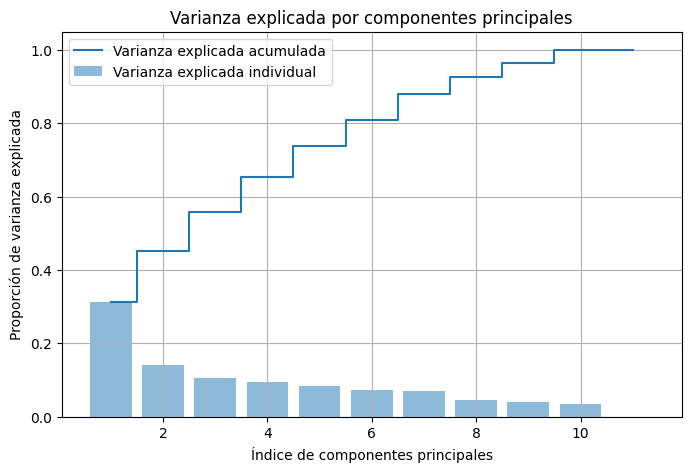

Top 8 Principal Components most correlated with 'Precio':
PC1    -0.507173
PC2     0.211277
PC10    0.188057
PC9     0.174758
PC6    -0.160656
PC7     0.160294
PC11   -0.124549
PC3     0.124354
Name: Precio, dtype: float64

--- Fold 1 ---


C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 71589.61, RMSE: 174205.32, MAPE: 30.78%

--- Fold 2 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 67633.83, RMSE: 161617.89, MAPE: 30.16%

--- Fold 3 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 68356.61, RMSE: 177073.34, MAPE: 28.78%

--- Fold 4 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 64317.87, RMSE: 146777.23, MAPE: 27.28%

--- Fold 5 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 63502.03, RMSE: 146940.52, MAPE: 27.45%

--- Cross-Validation Metrics ---
Average MAE: 67079.99
Average RMSE: 161322.86
Average MAPE: 28.89%


In [13]:
#Normal DNN 
precio_corr, pca, principalComponents= pca_dimension(df_base)
top_n_principal_df_base = transform_pca_n(8, precio_corr, pca, principalComponents, df_base["Precio"])

df_used = top_n_principal_df_base

model = Sequential([
    Dense(512, input_dim=df_used.drop(columns=['Precio']).shape[1], activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss=loss_function)

y_test_base, y_pred_base = train_test_model_kfold_with_early_stopping(model, df_used, 30)

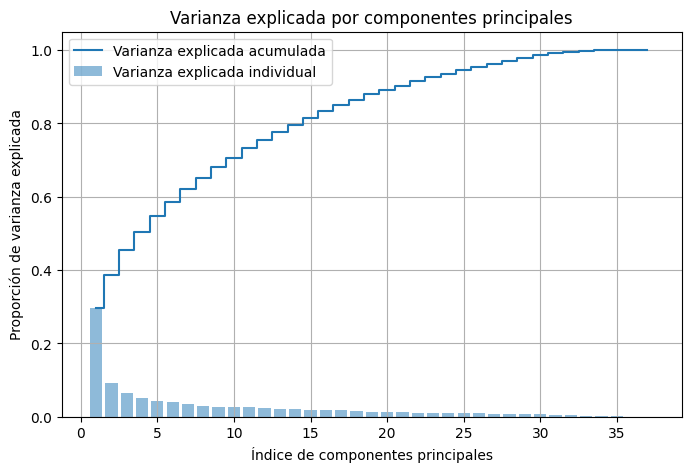

Top 15 Principal Components most correlated with 'Precio':
PC2     0.661183
PC6     0.140262
PC5    -0.137770
PC20    0.121952
PC24    0.107348
PC14    0.106261
PC4    -0.099318
PC16    0.089163
PC9     0.077813
PC3     0.075238
PC25    0.053470
PC1     0.053030
PC11    0.050436
PC21    0.043648
PC8    -0.038000
Name: Precio, dtype: float64

--- Fold 1 ---


C:\Users\emebe\AppData\Local\Programs\Python\Python39\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


427/427 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step
MAE: 60563.10, RMSE: 139427.89, MAPE: 26.45%

--- Fold 2 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 57564.55, RMSE: 140648.80, MAPE: 25.11%

--- Fold 3 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 936us/step
MAE: 57167.91, RMSE: 145398.40, MAPE: 25.55%

--- Fold 4 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
MAE: 51198.06, RMSE: 119088.60, MAPE: 22.51%

--- Fold 5 ---
427/427 ━━━━━━━━━━━━━━━━━━━━ 0s 949us/step
MAE: 48279.51, RMSE: 117957.66, MAPE: 20.87%

--- Cross-Validation Metrics ---
Average MAE: 54954.63
Average RMSE: 132504.27
Average MAPE: 24.10%


In [15]:
#Normal DNN 
precio_corr, pca, principalComponents= pca_dimension(df_microscore)
top_n_principal_df_micro = transform_pca_n(15, precio_corr, pca, principalComponents, df_base["Precio"])

df_used = top_n_principal_df_micro

model = Sequential([
    Dense(512, input_dim=df_used.drop(columns=['Precio']).shape[1], activation='relu'),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(16, activation='relu'),
    Dense(1, activation='linear')
])
model.compile(optimizer='adam', loss=loss_function)

y_test_micro, y_pred_micro = train_test_model_kfold_with_early_stopping(model, df_used, 30)

In [18]:
explain_dimention(1, pca, df_microscore)

                         Feature   Loading  Importance  Normalized Importance
1                          Aseos  0.374523    0.374523               0.084313
0                   Habitaciones  0.333856    0.333856               0.075158
8                RentaBrutaHogar  0.329899    0.329899               0.074267
5                         Metros  0.323921    0.323921               0.072922
36         Caracteristicas_House  0.319476    0.319476               0.071921
34     Caracteristicas_Apartment -0.317082    0.317082               0.071382
9              RentaBrutaPersona  0.307691    0.307691               0.069268
7                       Longitud  0.198623    0.198623               0.044714
3                        Piscina  0.197908    0.197908               0.044553
32        Metro Station_Distance  0.173647    0.173647               0.039092
2                        Terraza  0.149018    0.149018               0.033547
13                 %_agricultura -0.137071    0.137071          

C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:156: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_blue = df_plot_base.groupby("log_bin")["%error"].mean().reset_index()
C:\Users\emebe\Documents\GitHub\tfm_cleaned\plots.py:163: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  result_red = df_plot__micro.groupby("log_bin")["%error"].mean().reset_index()


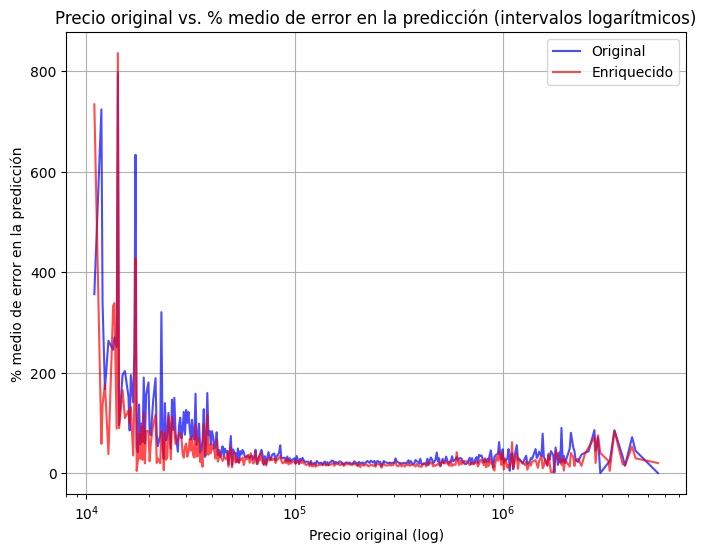

In [17]:
fith_plot(y_test_base, y_pred_base, y_test_micro, y_pred_micro)